# Test modeling on larger synthetic dataset with 300bp
Use 5g sequences but score them simply.

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


## ** Classification on balanced randomly generated sequences
* overfit first?

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7)
import seaborn as sns
import tqdm

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Generate Synthetic data

In [3]:
# add synthetic score column
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

m1 = "CACACA"
m2 = "GTGTGT"

def classify_seqs_motif(seqs):
    data = []
    for locus_tag,seq in seqs:
        seq = seq.strip("N")
        if (m1 in seq and m2 in seq):
            print("both motifs in seq - skipping")
            c = 'skip'
        elif m1 in seq:
            c = 2
        elif m2 in seq:
            c = 1
        else:
            c = 0
        data.append([locus_tag,c])
        
    df = pd.DataFrame(data, columns=['locus_tag','reg'])
    return df

def print_motifs_in_seqs(df, df_name, m1, m2,seq_col='upstream_region'):
    print(df_name)
    seqs = df[seq_col].values

    print(f"{m1}:",len([x for x in seqs if m1 in x]))
    print(f"{m2}:",len([x for x in seqs if m2 in x]))

    print(f"NO {m1}:",len([x for x in seqs if m1 not in x]))
    print(f"NO {m2}:",len([x for x in seqs if m2 not in x]))

    print(f"BOTH:",len([x for x in seqs if (m2 in x and m1 in x)]))
    print(f"NEITHER:",len([x for x in seqs if (m2 not in x and m1 not in x)]))
    
def balance_seqs_for_motifs(seqs, m1, m2,minority_target,majority_target):
    both_seqs = set([x for x in seqs if (m2 in x and m1 in x)])
    m1_seqs = [x for x in seqs if (m1 in x and x not in both_seqs)]
    m2_seqs = [x for x in seqs if (m2 in x and x not in both_seqs)]
    neither = [x for x in seqs if (m2 not in x and m1 not in x)]
    
    print("FIRST PASS")
    print(f"{m1}:",len(m1_seqs))
    print(f"{m2}:",len(m2_seqs))
    print(f"NEITHER: {len(neither)}")
    
    # downselection
    if len(m1_seqs) > minority_target:
        m1_seqs = u.downselect_list(m1_seqs,minority_target)
    else:
        print(f"Only have {len(m1_seqs)}... can't reduce m1 to {minority_target}.")
        
    if len(m2_seqs) > minority_target:
        m2_seqs = u.downselect_list(m2_seqs,minority_target)
    else:
        print(f"Only have {len(m2_seqs)}... can't reduce m2 to {minority_target}.")
        
    
    #majority_target = int(bal*np.mean([len(m1_seqs),len(m2_seqs)]))
    if majority_target > len(neither):
        print(f"Only have {len(neither)}... can't reduce to {majority_target}.")
    else:
        neither = u.downselect_list(neither, majority_target)
        print(f"NEITHER ds: {len(neither)}")
    
    balanced = m1_seqs+m2_seqs+neither
    print(f"BOTH:",len([x for x in balanced if (m2 in x and m1 in x)]))
    
    print("\n SECOND PASS")
    print(f"{m1}:",len(m1_seqs))
    print(f"{m2}:",len(m2_seqs))
    print(f"NEITHER: {len(neither)}")
    
    random.shuffle(balanced)
    return balanced

In [4]:
seq_length = 300
syn_seqs = []
#for i in range(10000):
with tqdm.trange(12000) as pbar:
    for i in pbar:
        if i%1000 == 0:
            pbar.set_description(f"i:{i}")
        my_seq = ''.join(np.random.choice(('C','G','T','A'), seq_length ))
        syn_seqs.append(my_seq)

min_targ = 300
maj_targ = 10000
syn_seqs_balanced = balance_seqs_for_motifs(syn_seqs,m1,m2,min_targ, maj_targ)

i:11000: 100%|██████████| 12000/12000 [00:00<00:00, 13142.47it/s]


FIRST PASS
CACACA: 753
GTGTGT: 712
NEITHER: 10483
NEITHER ds: 10000
BOTH: 0

 SECOND PASS
CACACA: 300
GTGTGT: 300
NEITHER: 10000


In [5]:
syn_df = pd.DataFrame(enumerate(syn_seqs_balanced), columns=['id','seq']) 

syn_motif_dict = dict(classify_seqs_motif(syn_df[['id','seq']].values).values)
syn_df['reg'] = syn_df['id'].apply(lambda x: syn_motif_dict[x])
syn_df = syn_df[syn_df['reg'] != 'skip']
syn_df.head(5)

,id,seq,reg
0,0,TAGCGATCACCATCCGTGTCTGAGTCGCTGCTGTTTCTGAACGAGC...,0
1,1,CATACTTGGTTTGGCCGGCTCCATATCGGACCAGCGCGATACTAAC...,0
2,2,GTTTTATCATCCTAGTGCGCCAAGACAATCGGCCCAAATTGTTGTG...,0
3,3,AACTGAGTGACGATACATACGTGGCAAACCACACCGTGGTGGCGCA...,0
4,4,GCAAGCATGTCGAAGGTGCATGGAATGTCCCCATGGGTACATTTGC...,0


In [6]:
syn_df.value_counts('reg')

reg
0    10000
1      300
2      300
dtype: int64

In [7]:
print_motifs_in_seqs(syn_df, "syn 10K", m1, m2, seq_col='seq')

syn 10K
CACACA: 300
GTGTGT: 300
NO CACACA: 10300
NO GTGTGT: 10300
BOTH: 0
NEITHER: 10000


In [8]:
syn_motif_dict = dict(classify_seqs_motif(syn_df[['id','seq']].values).values)


In [9]:
loc2seq = dict([(x,z) for (x,z) in syn_df[['id','seq']].values])

#print(locus2info['4'])
print(loc2seq[4])

GCAAGCATGTCGAAGGTGCATGGAATGTCCCCATGGGTACATTTGCCAATCTCAGGGTTAATAATTGTAATACACTCCTGACCCCGATCTACTTCTTATGGTAGGGTAGGGAAATTATTGGTCTAGCGCAGCCTATGATGACATAACCGCGGTAGGACGTTACGAATTCCAGGCGTTTAAAGGTCATTTCCAGACTATTCGCGGTGACTGTTAACCCGAGCCATATACAAGTGTGCTGCAGTTAAATATAAGAATATGGTCTGCTCATCACAATCATAACAGAAAAGGGCCGTGATGGTC


In [10]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x='reg', y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

def see_batch_class_dist(train_dl):
    '''Check distribution of classes in each batch'''
    
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in [0,1,2]:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()


## Load 5G seqs into data loaders

In [11]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [12]:
full_train_df,test_df = tu.quick_split(syn_df)
train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='seq',
    target_col='reg',
    sampler=None
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

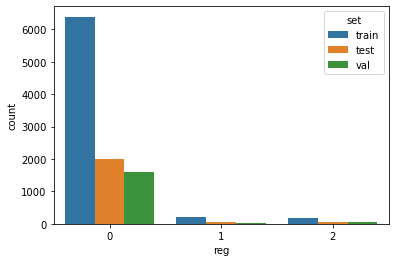

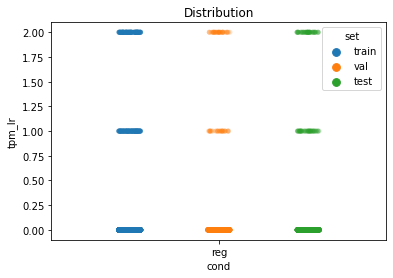

Train Seqs
CACACA: 188
GTGTGT: 202
NO CACACA: 6596
NO GTGTGT: 6582
BOTH: 0
NEITHER: 6394

Val Seqs
CACACA: 46
GTGTGT: 36
NO CACACA: 1650
NO GTGTGT: 1660
BOTH: 0
NEITHER: 1614


In [13]:
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='reg')
view_train_test_dist(train_df, test_df,["reg"],val_df=val_df,id_col='id')

print_motifs_in_seqs(train_df, "Train Seqs", m1, m2,seq_col='seq')
print()
print_motifs_in_seqs(val_df, "Val Seqs", m1, m2,seq_col='seq')

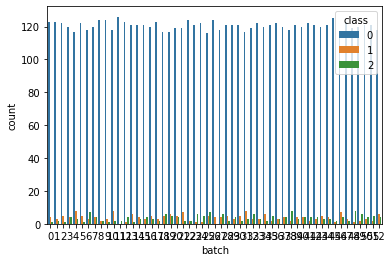

In [14]:
see_batch_class_dist(ohe_train_dl)

## Non-optuna regular ol training

In [15]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    #for epoch in range(epochs): #tqdm?
    with tqdm.trange(epochs) as pbar:
        for i in pbar:
            
    
            train_loss = train_step(model, train_dl, loss_func, opt)
            train_losses.append(train_loss)


            val_loss = val_step(model, val_dl, loss_func)
            #print(epoch, val_loss)
            val_losses.append(val_loss)
            
            pbar.set_description(f"E:{i} | train loss:{train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, loss_func, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

In [16]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            #nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            #nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [17]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        
        dfs[model_name] = (c,df)
        
    return dfs

### Deep linear

E:499 | train loss:0.001 | val loss: 0.601: 100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


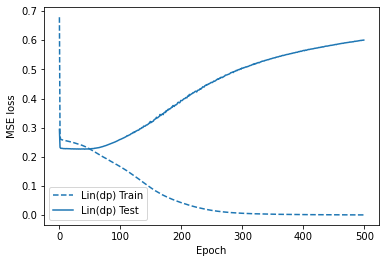

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [18]:
seq_len = len(train_df['seq'].values[0])

mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    loss_func,
    lr=0.01,
    epochs=500
)

# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)")]
tu.quick_loss_plot(mer8motif_lin_d_data_label)

mer8motif_model_lin_d

### CNN model

In [19]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 10,
                 fc_node_num1 = 10
                ):
        super().__init__()
        
        self.seq_len = seq_len
        
        # calculation for number of linear nodes need to come after final conv layer
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1
        #linear_node_num = linear_node_num*num_filters0
        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
            nn.Dropout(0.5),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully connected layer 0
#             nn.Linear(fc_node_num0, fc_node_num1),
#             nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num0, 3),
            #nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

In [20]:
# make model
seq_len = len(train_df['seq'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=6,
    kernel_size1=6,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,10.0,10.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=5000,
)

# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label)

mer8motif_model_cnn

E:2336 | train loss:0.077 | val loss: 0.397:  47%|████▋     | 2337/5000 [06:51<07:47,  5.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Running LinearDeep
Running CNN
Running LinearDeep
Running CNN


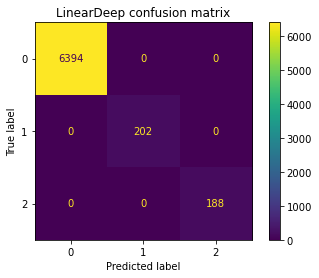

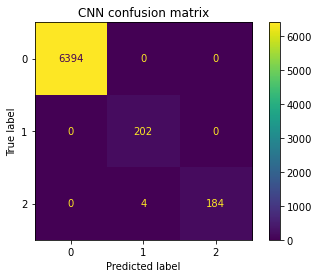

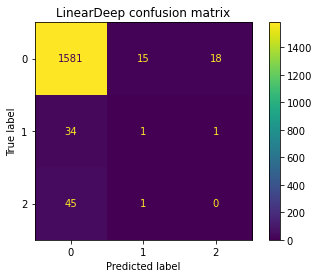

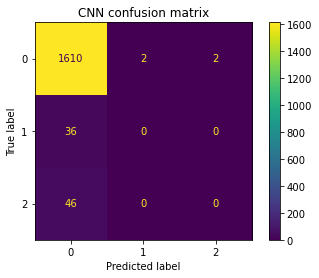

In [21]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['id'].values #val_df['locus_tag'].values #
val_seqs =  val_df['id'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in syn_df[['id','reg']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

In [22]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,precision_recall_curve

def cls_report(df,model_name):
    '''Basic print out of precicion/recall/f1 scores'''
    
    acc = accuracy_score(df['truth'].values,df['pred'].values)
    print(f"{model_name} (acc={acc:.3f})")
    for a in ['micro','macro']:#,'weighted']:
        p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")

def quick_classify(model, seqs,oracle):
    '''Given some sequences, get the model's predictions '''
    mis_classified = []
    for gene in seqs:
        dna = loc2seq[gene]
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        prob,cls = pred.topk(1)
        actual = oracle[gene][0]
        correct = (cls.item() == actual)
        if not correct:
            #print(f"{gene}: pred:{cls.item()} actual:{actual}")
            mis_classified.append(gene)
            print(f"{gene}: pred:{cls.item()} actual:{actual} ({pred.tolist()[0]})")

    print('done')
    return mis_classified
        

In [23]:
lind_res = dfs_val['LinearDeep'][1]
cnn_res = dfs_val['CNN'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")

LinearDeep (acc=0.933)
micro: p=0.933	 r=0.933	 f1=0.933
macro: p=0.337	 r=0.336	 f1=0.335

CNN (acc=0.949)
micro: p=0.949	 r=0.949	 f1=0.949
macro: p=0.317	 r=0.333	 f1=0.325


In [24]:
mis = quick_classify(mer8motif_model_cnn,val_seqs,oracle_syn)

16: pred:0 actual:1 ([8.619258880615234, -4.927402496337891, -4.640107154846191])
235: pred:0 actual:1 ([6.3667731285095215, -3.5629560947418213, -3.4115283489227295])
337: pred:0 actual:1 ([5.182056427001953, -2.9658498764038086, -2.7178053855895996])
671: pred:0 actual:2 ([6.710212707519531, -3.9029557704925537, -3.6620736122131348])
706: pred:0 actual:2 ([6.174778938293457, -3.4839088916778564, -3.2575244903564453])
851: pred:0 actual:1 ([9.058448791503906, -5.268186569213867, -4.9319539070129395])
954: pred:0 actual:1 ([11.820131301879883, -6.7685699462890625, -6.418033123016357])
1282: pred:0 actual:2 ([4.03522253036499, -2.314037322998047, -2.1288280487060547])
1392: pred:0 actual:2 ([7.312809944152832, -4.162479400634766, -3.885183811187744])
1427: pred:0 actual:1 ([8.723511695861816, -4.995972156524658, -4.681375980377197])
1760: pred:0 actual:2 ([5.146337032318115, -3.0109941959381104, -2.788187265396118])
2078: pred:0 actual:2 ([2.1611382961273193, -1.5965735912322998, -0.711

In [25]:
for x in mis[:5]:
    print(f"{x}:{loc2seq[x]}")

16:TGGGGGGGAACCCACATGCCTTCAGTGCCCAACTATCGGCGTCCACAGTACCTATTAGCGCAGCGACGGTTACCCGTGATGAAGCTAGGACTGAACTAGTTCGGTTTATCGGTCCATCCTGAACTGAATCTGATCTGATCAGGCCTTGACGCCCCGCGAATGTTGCTTTGAAATAGATGAGATTACGAATGAGGTAATAAAAATATGCAGGCCATAGAACGTCGACTTACACTCTAATACAACTCCGAATGAGAGACCCATGCCGTTGGTGTGTTGGATACACGGGCGGTAGTATTGCCA
235:GTCAGAAGCTAAGAAAGGCAGTGGACCTCACGTAGTGGTCATCTCCCCATGACAACCACTTGTGTGTCACAGTAGAAGGTTATAACGGCCCGTAGGGACTGGACAGAGCGCATCAGTGGAGCGAACTTCCGTCTCATCAGTGTGGTGTACGTTGTTGCAGTAGCAGTACTCTCCTCAAAAATTCAACGAAACCCTTGACACTGACTGTACGAATCGTAAACTAACAAATCCGCCGACGATACGTCCGCGGACGACCCAAACACCAAGAACGAGTAGTAATAGGTAGGGTAGCGAAGCGCC
337:GCAAGGACGCCGATAGGCTCGTTTCCTCGGTAACCTAACAAATAGCCCCCCAATCTATAGGCACTGAAGAGTGTGTTCCATGACCCGCACAGTACTTGTATTTTGCAGTCGCCTCAACTTACCACAACACGAGATGACCAGGATTCCCGCGACGATAGGTTCCCAGCGACCGAATCTAGAAGGACCGGGGTCCGAACAAACTTCTTTCAGGATTACTCTTAAAAGGCGCGACAGTATGGGCAGACAAGCCACCGATTTGGAGCCCTAGGACGACTATTGCGACCATGTTGCGGTCTAAGC
671:CATCCGTAAGGCGTACGCGCCCAACCGGGACGGTACGGGCACTCACAGAGATATGCCTATCTCAAATTTATTTTACAGCTGC

## Rebalance sampler

In [26]:
from torch.utils.data.sampler import WeightedRandomSampler


In [27]:
# retry making dataloader with weighted sampler
class_sample_count = train_df['reg'].value_counts().values
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_df['reg'].values])
samples_weight = torch.from_numpy(samples_weight).double()


sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
sampler

In [28]:
print(samples_weight.unique())

tensor([0.0002, 0.0050, 0.0053], dtype=torch.float64)


In [29]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='seq',
    target_col='reg',
    sampler=sampler,
    shuffle=False
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [30]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(8480, 4)
(2120, 5)
(6784, 6)
(1696, 6)


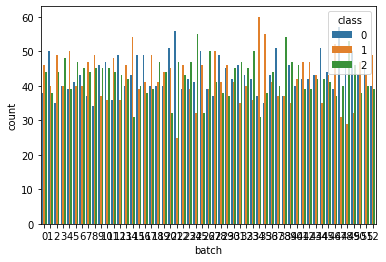

In [31]:
see_batch_class_dist(ohe_train_dl)
# the exact dist changes everytime

In [32]:
# make model
seq_len = len(train_df['seq'].values[0])

mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=6,
    kernel_size1=6,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=5000,
)

mer8motif_cnn_rw_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN rw sample')]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label+mer8motif_cnn_rw_data_label)

mer8motif_model_cnn

E:1499 | train loss:0.168 | val loss: 0.489:  30%|██▉       | 1499/5000 [04:25<10:12,  5.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



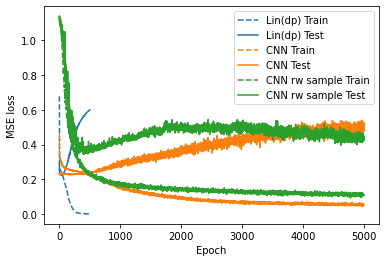

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2976, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [37]:
tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label+mer8motif_cnn_rw_data_label)

mer8motif_model_cnn

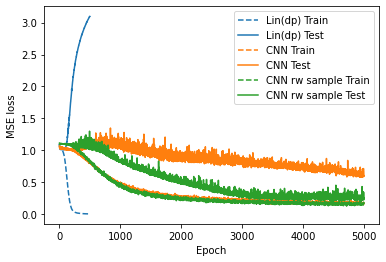

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2976, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

Running CNN
Running CNN
Running CNN


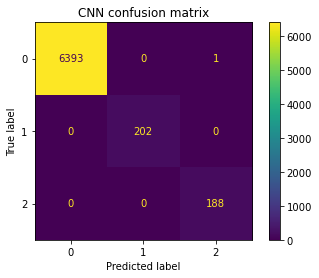

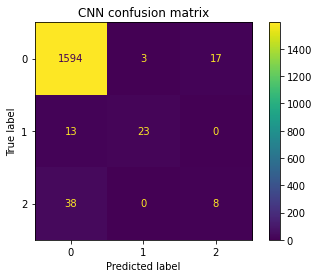

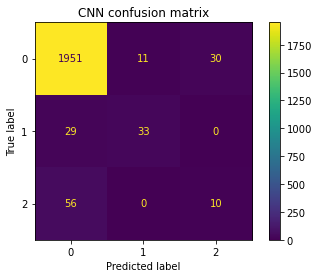

In [38]:
models = [
    #("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['id'].values #val_df['locus_tag'].values #
val_seqs =  val_df['id'].values #val_df['locus_tag'].values #
test_seqs =  test_df['id'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in syn_df[['id','reg']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])
dfs_test = plot_confusion(models, test_seqs, oracle_syn,[task])

In [39]:
cnn_res_rw = dfs_val['CNN'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")
print()
cls_report(cnn_res_rw,"CNN RW")

LinearDeep (acc=0.933)
micro: p=0.933	 r=0.933	 f1=0.933
macro: p=0.337	 r=0.336	 f1=0.335

CNN (acc=0.949)
micro: p=0.949	 r=0.949	 f1=0.949
macro: p=0.317	 r=0.333	 f1=0.325

CNN RW (acc=0.958)
micro: p=0.958	 r=0.958	 f1=0.958
macro: p=0.725	 r=0.600	 f1=0.649


In [35]:
mis_c = quick_classify(mer8motif_model_cnn, val_seqs, oracle_syn)

16: pred:0 actual:1 ([14.79306411743164, 7.9810075759887695, -23.79542350769043])
337: pred:0 actual:1 ([19.11402130126953, 18.007606506347656, -38.663330078125])
671: pred:0 actual:2 ([10.684109687805176, 1.5483791828155518, -12.875960350036621])
706: pred:0 actual:2 ([9.50761604309082, -8.785845756530762, -1.0389502048492432])
1030: pred:2 actual:0 ([2.3948206901550293, -5.828998565673828, 3.4066050052642822])
1073: pred:2 actual:0 ([3.9491941928863525, -10.287064552307129, 6.519923210144043])
1385: pred:2 actual:0 ([3.794177770614624, -8.16604232788086, 4.399174690246582])
1392: pred:0 actual:2 ([10.236555099487305, -3.2646031379699707, -7.40450382232666])
1521: pred:2 actual:0 ([4.63160514831543, -11.430789947509766, 7.001477241516113])
1760: pred:0 actual:2 ([7.772804260253906, -5.427577018737793, -2.709886312484741])
2140: pred:0 actual:1 ([16.84442138671875, 15.700186729431152, -33.89834976196289])
2190: pred:2 actual:0 ([0.2656469941139221, -1.3476687669754028, 1.18010854721069

In [36]:
for x in mis_c[:5]:
    print(f"{x}\n{loc2seq[x]}")

16
TGGGGGGGAACCCACATGCCTTCAGTGCCCAACTATCGGCGTCCACAGTACCTATTAGCGCAGCGACGGTTACCCGTGATGAAGCTAGGACTGAACTAGTTCGGTTTATCGGTCCATCCTGAACTGAATCTGATCTGATCAGGCCTTGACGCCCCGCGAATGTTGCTTTGAAATAGATGAGATTACGAATGAGGTAATAAAAATATGCAGGCCATAGAACGTCGACTTACACTCTAATACAACTCCGAATGAGAGACCCATGCCGTTGGTGTGTTGGATACACGGGCGGTAGTATTGCCA
337
GCAAGGACGCCGATAGGCTCGTTTCCTCGGTAACCTAACAAATAGCCCCCCAATCTATAGGCACTGAAGAGTGTGTTCCATGACCCGCACAGTACTTGTATTTTGCAGTCGCCTCAACTTACCACAACACGAGATGACCAGGATTCCCGCGACGATAGGTTCCCAGCGACCGAATCTAGAAGGACCGGGGTCCGAACAAACTTCTTTCAGGATTACTCTTAAAAGGCGCGACAGTATGGGCAGACAAGCCACCGATTTGGAGCCCTAGGACGACTATTGCGACCATGTTGCGGTCTAAGC
671
CATCCGTAAGGCGTACGCGCCCAACCGGGACGGTACGGGCACTCACAGAGATATGCCTATCTCAAATTTATTTTACAGCTGCAAACCAAAGGGTACAATAATGTACAAAGTTGCAACATATGGACAGGTACCCCGCTACACACAATCCCCGAGTACCTCTAAGTTCCGTCTTATTTCCCTTCGTAAATCGGAGGGATCGGTCTGTGTGGAAACAGTGCACATAGCTCCCACGTCACACAGTGCGTCAAACCGCGCCTAAACACTACCGAACCCGCAATAGGAGTCGACGGACAGGTCGGG
706
GCCCCGGTTATGATAAACGGCAGAGGGGACTTTCTAGCCCTTGAGATGAAGCTTGTGAGGACCAACCGGAAAGGGCATAGGC

# filter viz

In [38]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


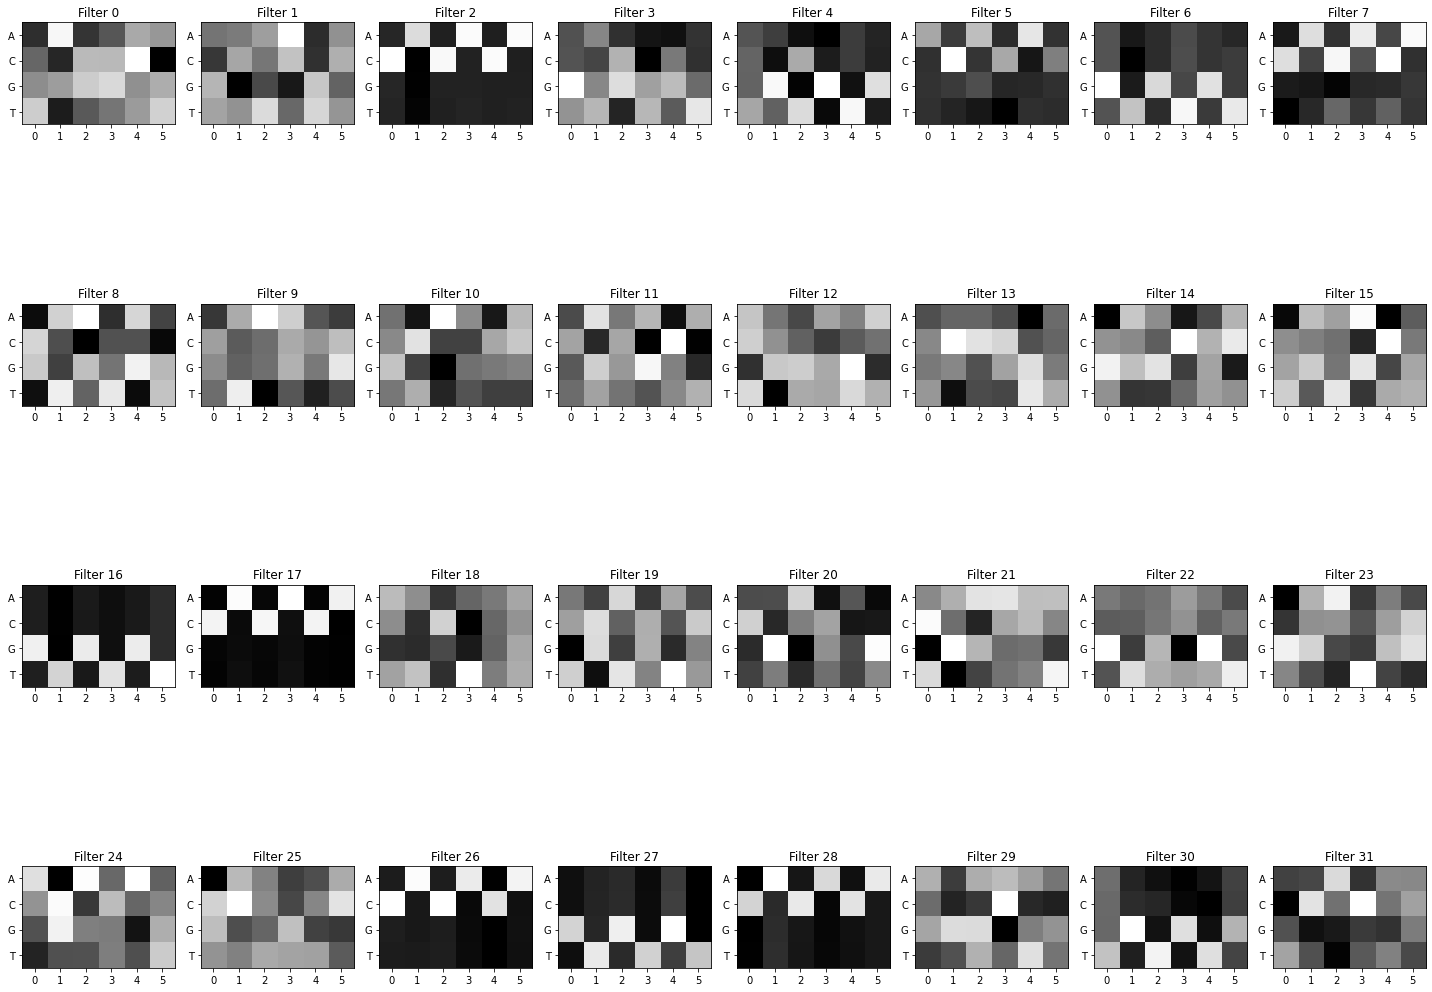

In [39]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)
view_filters(model_weights)

In [40]:
seqs = [loc2seq[x] for x in train_df['id'].values[:500]]

filter_activations = get_filter_activations(seqs, conv_layers[0])

Num filters 32
filt_width 6
Running seq CCCCCCGCGTTTTTCATATTCATCTAGCGGAACTCAGACTCTAGTCGGTTTAGGGGGTCAACTCCTCACCAACTGTAGTTCGAATCACTCCGCACTATCGGCATGAGAGATTGAGCGTGGAAACGAAATATCTTCTCCGTTGTTTCGTCAGTCGGGTTGGGACGCTGGCGGTGTTCCGGGGCGCGACCATGCAAGTGCGGCCGTCCGGCGGTATCAATTAGTGCAACCTCTCGACGCAATACCGGATACGACCACATATGTGCCCATAGGCAACCTATGTCCCACCTCGTATTCAAGAAA
Running seq GCGTCTGGATCGATCCAGGCTAGCAATCCGCCATTCCACGGTCCGCCCAGCGAGAAAACGTGCCTCAGGACAGGTCGTGCCTACGGCGTGCGTGATTCAGGACAAGGGCGGTCGGTGCGTCTTCTTAGAGCTGGATACAATTCCAAACGATATTTTGCTTACTGTATTTGGTCGTAATAGGACAACCGTTCGCATAGGCTTTTGACCGAGAACGAGTAGACGGATCAGGGCTAAACCTACGCCAACGCGTACTGTAAGGGACCGAGCGGGATAGGGAGGATCGTATGCCTTTGTATGAGG
Running seq CTTCCTTAAACCGTTGTCGCAAGAAACCTTATCAAGTAGCTGAAACTTACTGAATTCATGGTCAGAGGCCCTTAAGGCCCTTACTCATGGGATCTATGCGTACCGTGTTAGGCCTCATTAGTCGTAAGACAGGATCATATAAACCCATGTCCTTCCCTGGTCACGTGCCGCCATAAGCGCCATTTGATCTCCGATCTGAGTATGTTACTTCTGGTCCGAGCTAGGGTTCCGGGTAAACTGCAGTCTCGAAACGCCGAACCCTCCCCGAGGCATGCTTGTTAGTTCTAGCAGTTCCCATCT
Running seq CAATGTCCTCTCCCTCTTAAG

Running seq CTTAGGGTAAACAAGCAAAGATTTCTAAAAGGCTTCCGTAATTACCCTTGTCCTATCCGTGGGTCCTCTGCCGGGCCAGGCTGAATGATCCAGGGGGGCCAAACATCGTTATAGGTTTGTGGAGACGGTCGATTGACTAACAGGTGCGCGCACTTTTTACGATGAGAGATATTGGAGGCTATCTAAAACTAGAGGTTAGGTTGTTGTCCTATACTCCTGTCGACGTACCACCCGGCGTGACGTCCATCGGCCACCCTTGAGTGCCCGGCGCCCACTCCAAAATAGACGGGCTCGACTAGA
Running seq TAGGACGATCAGCCGGATGCGGTTAAGCCGTCGTAGCCCCTTGATGCAGTCCTATCTTTGATTGCTCTAGTTACGAACGACGGGTATATAGGAACTAACCCATCGACCGATCTTCATGTCAGGCGATTAGCACAGGGTTACTTCTGTTGCTGACGTTGATTAACGGAGGACATTGGTTGAACTTCTGAGACGGTACGGGTTAACTGAAAAAAAGAGGGCTAACTAACGGGAAAGCAACTTAATTATAGCGTTCAGAAAATCCTGGATGCTATCGTATAGATCAATTCATGCAGTAGTATC
Running seq ACAATCAGAAAACATGTGTGAGCTTAATATATGCAGGTGATCCTCCTGATCGAGCGACACATTCGAAGATCGTCTCAATTGCAAGATTTACACCGAGGGATTAGCGTTTAGCCTATCGGGTAGCGACAATCGCGACTCGCTTGGCTTATATATTTTTTCCTGAAAATTGGCCACGCGAGACTGGACTACTACCGCGCCACACATGTTATGCACACGCATACAATGCCGAGTGCACTCGGGGCTGTAGCTGTGATCACGAGTTTTAATCCGATCTACCCGAACCCGCTCTTCGTGTATTTT
Running seq AATGGTAGCCACGCTAGGGGATACGTGATGAAACAAATTTTCACCTTTG

Running seq TCAGCGTTTCCTGAATAGTTCGTGTAATCTTGTGTGAAGGCATCTTGAGATGCGATGTAACGGCGGAGGGCTAAACATGGTGACTTACTGTAGTGGGCTTCTCAGATCGTTTAGGATTTCGCTTCCAATCCAGGTAGTAATCAGATCAACTTTCCTGCGCTCCGGAATGAGATAACTCTAATTGAGGCCCCCGGGAACATGGTTTGAATTTCGCAGCTGAATATCGCTCCAGAGTTCCACGGCCTCCAAGCAACGGACCAATCTGTTACCACAAGGCAAAGCGTCCCCATATGTCGTCTC
Running seq CGTTACTGCCGAAGGCGGTATGAGCACCCTATCGGCATATTGAGCTACTTGAGGTATGCCGCGCGTGTGGCATAGCGTGTACTGTACGTAGCATAACTCCTTGAAATTGATAGGGATTTACAGGGTCATAGAGCGACTCTCAGGCGTTCTTCCCAACCACAGCGCAATCAAAGTTCGTAGATAGTAGAACAACTCCTTTCTGTTCGGGAAGGCCCGGCTAGGTATAAACATTAATACTAAGACACAATCAGAGTCTGATTACCACCTCGGCTAAGCGGAATGCAGAGCCTTCTCACGTGC
Running seq TGATGAAACTGACCGCAGCTGGGCCATGGAGATGATGCCGGGAAGGAAGACTACTCACATCCGTCCCGTAGGACTTGATAACGTCGTCTAGTGAAGGCTCGTGATCTGCAATATGGGAATAGGTTTTTCATAATTGATACCAAGCGCAGAATCGACCGCCGGGGCTGATTCGCTGAGAGCTCCCGAACCAGGAAATCAAGCACACAATCCGGATCCTTCCTTAACGCACGCCTTAGTAACACGGTGCAAGAAGGCTACTTACTGAAGGTGGATCTTATGGTCTGCTTTAGGTAACTTGCG
Running seq CGATGCGTGGACCGGGTATCCAAGTCAAAATATTACGGGCAATCTTAGG

Running seq TGCATTTCAAGTGAAAAGCAATCGAAGTATTCCAGGGTAAACAGGCGAACTGTCTAGTAATTTGTGCATTCTGTACGACTATCTACACGAGACATCGACAGAATCCATGGACGGCGCATCAAGTGCTCTTCGCTTTTTTTGATCACGAATCGATATCACCCGGGCCACTACTGCTATTCGGCAAACTTTACGTTACTTGTCGAGACTTATAGACTGTAGCCTTCTGATCAGACCGAGGTTCTCCATCAAGTGGCCGGGCGTTTGTGGCAAGCACGAGCCACCTCAGAGACTTATCAAGTC
Running seq CAGCGAGAACCTATCTCGTGCTACGTCCCTAAGTCAAAACGGGAAAACGTATTAAGTCGTTACCCTCATCCTCGCCTGATCTCATCTGGCTCGATCTTACGGGGTGCGGTGTGAGTCGATCACTATCTGAACGGATAATTTACATCAATGTTTGACTGGCACCCTGCCTGCCTATTAGTCTCCTTGACACAGCACCTTCCCTGGGCACTATCGGTAGGTATTCTATCTACGGGTTGAAATTACTCTAAGAGTCTATCTCACAGGATCGGCACGAAACTAGGTCCCCTGGCTGATGGGTTC
Running seq GCGCGCATCATAAGTAAAAGCTATTGCATTCCGGTGGGGTCATATGGCAGAGTCCCCAACGCCTCGCTTCTGAACGAAACTGAGTGATACGTCAGAAAGACATACGAGTTCGAAGCGCACATAACTCCATACTCCTAACCGATTACAGACGCTCAGCCGTGTTTCAGATGTGAGGGGCCTGTTGACCCAAGTCCTCCTGTGTTCGTTTGTCAACTGATGTAACTCTTTCATACTACCCGACAGACAGTCTGCTGATTTAGTCAATAAATGAAATGATCAAGAATCGACAGGCTTGTCGAC
Running seq CAATAAAATGATTAGCGTATCGCAGGAGAATCAACACTATCTTCACATG

Running seq CGGCGTCAACTAGCGAGCCGTTCGTCGCGATAGTGGTTAAGGTCTCGTCACCGTACTGCGATCACACCGTGCCACACGCTGATTTAACGACATACTCGGATTACCGCAAAATATAGAGGCAATGACTGCTATCGCGAAATGGTGGTGGCGGTGATATATCAAGTGGTGTTCCGCGGAATTCTCCCCCGAGAGACTAGAAACAAGTATTTAAGGAGGCCAAATTGGATCGTATCGTGCCTTCGCCCGTTGGACGAAACTTCATTGTTTGGCCACTAGGAGGACATCTACCCATAGTTATGT
Running seq CCTCCGGCGTGTATCATCAGAGCGGGCTACTTATTAGCCCCTCTACGAATGCCATTTAGGCTGCATTCAGGATGCTCACCTCAACCTTGCAGCCAAGTGGACCGGAGTGTAACCAGAACTGCACACCATTGCGGGTACACGATGTCTTTTTTAGTAAGGCCGAACGCGGAACCACTACAAAATCATATCATAAATGGGATCGCCTGGGGCCCCGACGCTGACCTACATTGCTGTGTCCATCCCGTCTATCGCCTGGTAACTGTTTACCCCTGGGTGTTTACCCCAACGAGAAATTTAAAG
Running seq AATCCCTAAGAAGTTCTCATAAACCCCTCTATAACGCCGCTTACCCCAACTTACATTCAGGGGGCGTTTGCTAAGACATACCGAATCCATAGTCCGCCGCCGACGGGGCCCAAATCCCGTCACGATGATAGTCTAGATGGCGCCGTTTGCTTCGCAGAACCGGCCGTACCACTCGTATGTATTATCAGCGGGCATACAGATATGTAATTGATCTTGTCAATAGTCTTGCCACTTTCGACCATATCTTACTTGTACCGTTCGTGGAGGCAGTAAGAGTTTCGCCAACTTTGAGATTCAGGA
Running seq TCGTTTATAATCTTGTCGCGCCGTGATGGAGAGGTTCTAGGGGATTCCA

Running seq CTGAACGTGAGTATTGTGCTTCCCATTCGAATGAAGATCGGGATTGGTTTGTTGGGCCGCATTGTTACCGGCTATCCGCTGATAGCGCCAGCCCATGTGTGTAGCCGCCTGTATACCTAGTAGGTAGACCGAATGCCATGCCCGGTGATTGGGCTTACTGGTCTCTTTATTCAACCCATGGCGAAATTAGGCTGCCTTGAGACTCCCTAACGTCAAAGAGCAGAGGTTCGGCTTGCTATGTAGGAAATCTACACGCTACGGTTGCTAATGATTTGAATATAGGACTTAGCATCAGTTTAT
Running seq ATGATCGATTGCCCGAGCTGGATTGTCTGACGAAGAATTTTAAAGCCTACTTATGGCGTCACGTATTTCTCAGATGCTGCCTTGCCCAACCACTCGATTCGATGGTCTTATCCTGCCCAGGCAACATGACGTCCGCTCATAGTAAGAGCAACTCCGCTACCCCATTGGCCGCCTGCTGGACGACCCAATTTACCCCTTCGCACCAAATACGTGATCTCATAGGAAATGCCTCAGCTGAGGACCCAGCCGCTGTGGTATTTTTCGAACGTTGAAATGCTCGCATGCAAAGTAACAACGCGA
Running seq CAACTATGTCCAACGGCACCTACCAGTCGTGTCCTTTAGAAGTGGCGCACATACCTACATACCGTGTAGAACACGGCGAGGTTATAGTCTTTTCATCTTCCTAACGTATAGATTCGCCATACCTCCGCTCGAACCACTCTCCTCGGAACTAAAACTACGCGTATCGCCGCGTCGAAGTGCAAAATTAACAGCCATAGTCTTATCGCTCATCTTAAATCAGAGTTAATATTCTACCTTCTCTTAATAGACGGCTTTGGTTCGCAACTCTTAAAGGCCTAAGACCATAATCTTCGCGGGATA
Running seq TCGACATCCTTCGCCGCCCTAAATTGCTGCGCTCGTGAGGCGCCCCTGC

Running seq AAAGCCACCTAACTGATCCACACGGTCAAAAACATTTACCATCTGCCATTGAGGCGGCGTAACACGTGCATCGGAGAACGCGTGGCATCAGCACTTGTGCAATGGCACACGGTTTCTTCGGTTTCTGAATGCACTGTGAGCTGGTATTCCCCTGGACCGCGAGACCCGTTGGCTAGCGGCAGCTGCGGGTAGACTGGACGGCGAACCGCCCTGGCTGTCCGAAAGGACTGGCTTTGCCATGGGAGCGACGTCGAGTAAATGAAGTCTACCAATCCACTCCGCTAATAGACGTCCCTGAAG
Running seq CTGGGCTTTACCAGTAGCCGCCGCGGAAAAACTGAAGTACAAATGTTTGTGTCGAGTCTGATCTATCAAAAGGTGACGCGTGAGGCCCCACATCATCTCCCATCGTAACGTCTCCAGTATTCGCGATGATCCGAATGTTTAATCGTTTCGACCCTTTCGCACAGGGCCATTCGTTGCCGAGTGTTTATCTTTGCTTAACGCGTAATAAATATTCGATGCCATTGGCGATTTGATCGTAACTCAAGTTGTTGGGACTATCGCGATACCGCTCGGTATCTGGATGCTCCTTACGCGGCCACC
Running seq ATAAGAAAGTACCACAGACTCTCACACAGAAAGCAAGGGAACCACATTTCTCGTTGGACAACAATTCTAGCGTTCCTCGGTTTCACTGGAAACCGAGTGATTGGTATTTGACTGCCAATTCGCGCATTGCAACTTAGATATGCCAGATAAATGGCCCGGCTAACATTGCTCAGCTAAAAAGTAAACAGGCCAAGATACATGCAACCTAGATTATTTGTACCGGATGTGCGCCTTCTGGACCCTCCGTTGGAGCACGCCTCGAATCATCTTAAGGACTGTTAATAGCCTTCTCGTACGTCC
Running seq TAACCTTCTTTAGTGACCTTCAACTAACAAGTGGTGTTACGTTGCATCC

Running seq AATAAAATTTCCAATATCGCGTTCCCATTTTCGCAAGAAATGCGGCGGGCGAGCGTAGAAGGTTAATTTACGTTTCACGACATACACAGATGAAGCCGACATTCACTCGAGAAGGTGAGAGCTTACTCAACATCGTAACCAGGCAATGCCCGCCCTCCGGTATCCCGTAATGAGTCGTGGACTATGTCTGTGCCGGTCCCTGGGCTGTTTACTCCGCCTAGATCGTCCGTACATGGCACCACCGAGGCGTCTGACTGACGGCTAAACGTCGGCCTGGTTACTGACCCTGTAATAAGACAT
Running seq CAAGACTCGCGCACTTATGCTGTAAACCGATTCTAGCGAGACTACGAGGGATGGCTCTGATTTTAGGTATATAGTAGACGCGGATACTCCTAACCGATGCCGCAGAACATGAGTTTCTTTAACCGGCTACGCAGCCGACTACGAACCGATGTGGACCAACTCAGTTGGGCACCATTTATCGCCGCACCCCTCTCATGTAATGGCGAACACAGTGAGACAGGGTTGCGGTAACGCGACAGAATGCTACGGCCGAGATCTCGATTTGTCCGGGCTTCATTTCACGGACGACGGTCAGCGTTC
Running seq CACAGGCCTGGTGACTCGACCTGGGTAAGCTTTGATGAAAACAATAACAGTTTGACCTTTGGGAAGTGAGTACATCTCGTTCCTTAACGATATTGCATCAGTCGCGCAGTTTAGAGAGCTTTCAGATCCAGCCCCTTTCTTGGAAGCTAGCCTGGGTATAACACCACGGCGTCCTAACTCGGTCCGTGCTACAAGAACACCTTGTTGGAGATGAATGGATGTGTCGCAAAAGGGGCAGACGTTTGTATATGGACGCGGGAGAGCCTGTAAACATTTAAATTCCTACATCTACAGAGTGAT
Running seq ACTCTCGCACAACATTGTGCCGAATGCAGTTTGGTTGATCGAATGATCC

Running seq TCGACAGGAGCAGAACACAGGTTGTTTGTATTCTCCCTGGTGGTGCCCGTTAGTATTAGATGTGCATACACAGTCGGTCGCAACCAACACCCGCACCATGGTTGTTCTAACTCTACAAATTTAGCTTAGTAACGTGACCTCGGAACTGTGGCGCTGAGACTGTTATTTAAGCGACCGTGAGACTTAACTTTTCCTACCCATTCCGGGGAGCTTGCACTTCGGCGTGGGCCAAGCAGCCTCGATCTAAATCAGGCGTGTTTACTCGACGGGGCTTCAGGTTCTGCAGGAGAGAATGCAGAG
Running seq GGAATGAGGTGCTTGTAGCCGCAATTTAGATCTGACTGACTTTTACAGCTGGCTACTGGCTAGCAGGCTAAATATTTATTTGCTCTTGTCAAAACAACGAAGATTAGTTTCTTTACTGCGCACTTTATGTTCTCCTCCCTAGAGTAATACGACTTATTTCAAACGTTGCCTACGCTAGTTTGGAGTAGCACCTAAACAACGGGACTCCACATAATTTCTCTATGAGCCCCCAATCGCGAGAGTACTGTGGCTACGGAATGAAAACCGATATTTGCGCTCGGGGTGCGCACATTGTCATGC
Running seq TGTCCACCCTGACCCGCAAGAACGTCACCTGGGCCGTCGTTCATGCGACTGTTCCCTGAATGTCGTCCTCTTGGAAAAGAGCCAGAGCCGAAAGACTGGGCACTTGGCGATTCTTGACCTCTGCGGATTTAACCCGGTTAGGGAGAAGAGGACTAAACTTAATTAGTAATCAGATTTTACTGCTAGTTCAAATCCTTTGTCACACCGTTGTACAGGGCAAACGCGTCGGGATGTGCGCATTGTATGGCTTTCGAATTAGCTTGCAGCCGGATTACCTATTGCTCAAGCCCGAATGCAAGA
Running seq CCGACTCCTAATCCTCAAGGTGTAGTGTCTCACAATCATACGGAGCTAT

Running seq TTTAAAACCTGCACTGTCATCCCGGAATACACCTTTTACGTTCGGTGAGCAATATTGGCTGGGTCGGTTAAGCCCGCGGCCACCAACGAATTAATAACAGTCATCCCGGTGAGAGGGAGTGCAGACCATCACGTCCCACAGATAACGAACAATCGATGTGAGAATCTAGCTACTAAGAGGGCGAGTCTGGGGCCTCGATGTGTGTTCTTCAAGCGCACTGGAGTCGTGATATTGGAAAGCTGTAAGAAACGCCAGGCGTCTAAATATGACCTCTTGCGTGAGCAACCAGTGCTCACTAAC
Running seq AGTCTGAAGACCTGTTTTTCTCTAATCGTGCGCCCAATATCTTTATACCGACGCTGAGAGTACCATCGTCGCGCGCTGTCTCATGAGTGCGACGTTTGTCCAGCCTCGAGCGGGCCAGTGGACAGTACCCCCCATACTTTACTTACATGTGGAGGCGTCGTAGAACTGGGGTGACGCCTTGAAAGTTTCTGTGCCGGTTGTCATTTTAATCGTACAAGTCCATGACTTATCTCTTAGTGATGATTTGTCGACGCTAATGATAGTATTGGTGCAACGCTAGCCTAAAATCACACCCGGCTC
Running seq ACAGACGTCGAGAGCCACCCCTATAATACAGTATCACCTGTATCACACCACGCCGCCGTGTAATTGACACGCGGGAGAACCGTCTAGAGCATCAGAACGAAGCCCCCGCTATAATGGTGGATTGTGGTCCTAGGGATTGGGGAACAATGATAAGGGTCGCCGGCTGTCCACTGGAACAAATTAGGCGACTTAAGGTTTATAATCTTTTTAGTGAAGGACCAAGTCAGGCAGCGGCCATTAGTGCCACCAGTTCGCGTTCCAAAACTCCTACCTACCTGTTGTACCCATCCTGTCTCACAA
Running seq CTAAGGCCCCCCGACAAATCCTTGTGTCTGACAAATCTCTATTTAACCG

Running seq CTGCACATCGGGCAGAGTTGGACGCTCCGTAAATGCCGGCAGAGGGTCATTGAAGTATTATTGAACTTCCACGATCTGCATAACCGGTCAGCTTTCCAGCGTGACACTGTAGTATGGGGCTTTTGACTTTCATGGCGAGGCCAAAAGTGAAGAATACATTGGCTAGAGTCTATGCCGATAAGTCCATTCAATACTAGAGCATTACAACGACATCTAGGCTCTTACTCGAGGCGTCGCCCCTCCGCTGCATCGTAGTCTACCCACTGAACCCAACTTACTGTCTTGAGGTTTGATGTGCTA
Running seq CTGCAATAATAAACTCCGCTACCGATATACACCGATAGAAAAGGTGAAGGAATCACCGAGATCTCTGCGAGGATGAAATGCGCAACTCCTTCAATCGACCCGAGGTGTGGATTTCGAACGTGCAGGCGACAATCAAATAGTGTAGCACACCTAAAGCTATAGCTAATGAGAGAGTTGACTTCAAGAGGGACCTTTATATAGTCAGCACGACAGACGGGAGTACGCCGCGTGCGACTCCATAAGGGATGACTCATCATGTCTAATCGGGTCGCATGTCAGGGGTCTCTTGTAAATATACAC
Running seq TCGAGGTAAAGGAACAATTGCGTGTACGGACTGCAAATTAAATTACACGCTTTAAACGCAGACTCCAAGATACCCGAGAATCAGTCATGAGCAGGCCTGATTTCGGTGTAATAAACATGGGTAATGACCATGTATTCGTAAGTCATGGCTTTTGGTGCCAATTGCATACTTCTTAATCTGCGTCCTATTGCCGTTTCCTTGTAGGAACGTCCGTGCGCACCATGGCATAGGGCGCTAGGGCGAGCGGCAATAATCGAGCGTTTGAATGAGGACCAGTTGTCTTACGTAATTCAGCCCATC
Running seq TTGGTCTTAAAGCTTCCGTTCTTTGCGGCCTCTATATGACCAGCCGGTC

Running seq AAACTTAACCGACAGGTCATCTGCGACAGGCTCTTAGATGTGATAAATCTGGAATTGACCTTCGACTTCACCCATCTTCGGTTTTCCGCCAGCAGCCACTTACTAGGGTTTACATCTTAGAAGGGTGGGGTTGGGACCTTTTCAAGTGCACAATGAGCCAAAGGAGGCTTAGCGTGCCAGCTGTCTTGGCTCGAGTACGCTAAATTCCTTTAGGATGAGAACCACTTTTGATTTAGGAAACCCATCGACTGCATAGCATCCACCTGAGAACCTAGAGTATGCGTTTATCGTTCCAGCGTG
Running seq GCCTTCCTTGCTCAGGTACTTTGTCTATTGTGAGTGCGAATCTTATATGCCTCCGCAAAGCGAGGGAGAAGAGTCAGGGCAACTATTTACATTGCATGCGATAGCGAAACCACTGACGGTGCCACGTACATACAAATTGTGCCCACCAAGTTTAATTGCCATGATGGAGATGGGGGCTATTCAGGCTTCACAAAGGTATCTCTAAATGCGGGAGATCAAAGAGGAATATAGCGTGGCTCCTATCCTGCTGAAGAATATCTGGGCGTGCCTCCCACCAGTCCTACTCCGCCTCAGGTAACG
Running seq ATTAGGTATATCCCAAAATGAACCTTTGGAAATTATTTCAATTCCAATTAACCCCTCTTCCACGGCAAAGTCCGACTAGGGCGAGGCAAAGGGCCTCAAGGAAGAAAGGCGCCCCGGTCGATCGAAACCATTGTAAGTAAGACGGCTCTATCATAATGTACCCAACTCCAGCCTATGCGGGCATTCAACTTCCTCTAGAACGTAATTTGTGGACATTCCATCGCTTGGTTCTAGAGGGCTTGGTCATACAGACCTAATAAGGTTAAAACCATCTGTTTCTTTAGGTTCTGAGACATGGGT
Running seq CACGGGTCGGTGCCAAGCACGATCAGATTGAAGGTAATTGGTGGGGGCT

Running seq CTCTAGGGGACAATATACTCTTCTACCAGCTCCGACCGTGCTACGTGCCCTATCTGTACTATCAGTTGAGAACGGGGGGCCCGATAGGGTATCATTGAAAACCCCCTAGTGTGCCTTCGACTTACGTATCATCTACTGGTGTCTCCCCCCTTTAGAGACTGGAACTGTCAAATTAGAGGTAAGAACGACAATGGGGCTCGCCCTGACCTAAAGTACCGATGCTAGCTCGGCAACAGGACATCCAAAAAGATGAACAAAATCGTCAACTGCGATCCGTGGTCTTGGCCGATTTACTTGCTA
Running seq TGCTTTGACTGCGTTACTTCGAATGTACTCTTCAGTGGCCCGATAATAATCCTTTTTAAGTAAGTTAATAGCTATTCCGGATGCCTGGTTGGGCACCCTCATCGAATTAAGTCCCCGGTTTGCGACCTCTAGGCGGTTACTTACGGAGGCTTTTAACAGCCATTGTAACCCACAACGGACCTCCTGGGATTGCTACCTGTGATATCTCCTGGGAAGTAATTTCAGTCTCTAATTGTCCGGGCTTGGAGCCACGGAGAATACTCAAATGCGGGTCAGACATACGCTGCGCTATTCAGACTG
Running seq AACAGGGTCAAGCACCCCACTAGCCAAGTGTAGATGGGGCGTCCGGTGTTTAGCCTAGCGTGTATTTTTTGGGAGAAGGTCGGCGTTAGCGATACATAACCATTATCCCTGTAGTCCAACAGCCACCGCATTGTTCGGGCACCATATTACCTGTGTTCGTACAGGGGATAGTGTGTAGTTACCTAGGGGCTAGACACCATATGACCGTAAGTGTAGAGTTCCCGGGTTGATCTACGAATCCTGTTGGCTCGGTTATTCTGACCCCTTTACTTCACTTTTTGCTTTTCGCTCACGTCCTGG
Running seq ATAAGGACAGAGCATACCCGTCCTTCCCTTTCTGCTCACTTCTAACCTC

Running seq TTAATACCTTGGCGTTTCGCGCGTCCCCAGGTCGCAAAGATCAGCACACAAGTTATGAGGCACACTACCGCGAAGCCTATACTTTATAGTTCCTTGCGTCATCGGCTATCTACATACCCACAGGGCTTGTGAGGTCCTTAACCGAGCTGTCCCTCCTGCCGCTATAACCCGGAGCGAATTCTGAAACCTCGGCAAGCGTCACCGGCTATATCCGGGGTCACATTTTGTATATTACTTCCTTACCCCTGTGGCAAGGTGCGAGGAGCCGAGCGAAACCCGGATGTAAGGGTATCGCTCCCT
Running seq GCACGTAAGGTCGTACGACAGGATTGTACGCGTGTGTGTCTACTGAAAATTAGGAGCGCAGTCCATTATGCTTGGTAGCGGATGGTGGGTGTGTAGCTAGTTTCTCAAAAACATTGAGTTGGTAGCACATAAGTAGCCCTGTAGATGGAAACAGAGGCGCCGTAAACGTGCCGCGCAACTCGACTTAGTACTCGCCATTAGCGGAAAGTCATCGTAGTACATGCTGTGCGCCCGTACTTCCCCAGCTGGGCCCTGTAGAGCCAAGGTGATCCGTCATCGATGTCCGCGTTCTATTAAATG
Running seq GCCCCGCGATTCCCGGACACCTGGTATGGCAACGTCAGATTGATCGCCTAGCCGTTCCCATTGGGATTAGCTCACTCGCGGTTAGGCCCATCACCCCTATATATTCTGAACGTAGCTGTTTTTGCACGGTGTTTGTGAATAATGTCCCGCCTCTAAACTTGCAGGTCCACTAACTAGGTTAGGAAGTTATCGTGCCGCCGTAGTCTTACATCACATGGATCTCCACCTCCGGACATAGCTGTATGATCCTCACGAATTTTTGTGCGGAAACTGGTTGACCAGGACCCTTCAGTGCTTCAC
Running seq CTGTTTAAGTTGAATCATCAGGAAGGTATTGCTATGCATGATGTCAATT

Running seq AAGCGATGCACATCAGGGGGTGTGACTTCCGAGGATTGGACATTCAAGGTTCTTAGGCCACTCACATTTTTATTACCGATATGTCCGGCCCTAGATTCACATAAAGAGGACACTAAACGGGCTGATATTTGCGTTATTCGACCCCTCAGTCTCCTCTAAACATGCCGGCACGCTGCGTTAGCGGCCAGTGGGTCAGTAGTGAGGCCAGTGGTTAGAGGTAATCAGTGGGAATACTCCGACGGTTTCGGAGACTTCAGCAAGCCCCTGAACAATCGCCCTAAAACTGGACGTGCCGGTGCT
Running seq GCGAAGAATGAAGAACATCTTCCTTAAAAGCAGAGAGACGCGACAACACACAGGTCGAAAAAATCCTGTCTCACTCGTTTAGATCCGTTTTCATCTAATTCTGTCTCCTCGGGGTACCATTCCAAATGCCGCTAATTACTTTACTGGGTTTCGGTCCAGAAGCTGGCTTATTTCAGGCTATTAGCGGCGTACGGCAGACCCTAAAAAGGCCCCTGTAATGTGATCAAGAGCGGCAGAGACACGTATGATGCGCTAAATTAGCGTACTGAGAAGAACTTACTATAGAAACTGGCGGGCCCC
Running seq ACCCTATACCGCATCAGAATGTCAACGAGTTGCTGCTGAGTCGCGTGTGTTCCACAAGAACTTGTGATAAGGCTATCATTGTGCATAACCGCCTCGGGGGTGTATACTAACATCCCGTATGAGGTCCGACATCTGCGCAAGTTCTGTGCTCACACCCGTCAACGCACTCGGCACCGGGCTCGAGACAACCCATCTAGCCCGGATTCTGGCCCCCTCAGTCCTCGTGCGTCAGGCAGTGTCAAAATGGCCCTTGTTATGGAATGCAGATCGGTCAGGGTTCTGACTTGTCATTGGTTTCTG
Running seq TCCTCTCCGATTTGTATTTTTAATAGTAAGTGAGTATCCCGCAAACCCG

Running seq GGGTAACTCGGCATCCATGCTCTAATCGACGATTGTCAATGGGAAATCCATGTCAGAATGTGCTTAGAGTTCTTCATGACTTTGATTTTGATAGATCGGAGATAATAGGGTGTATCGTCCATGCAGTGTTCCGTGGAAGATTACGTCAGCTTAATCGGTATTAAGTGTTCCCCAAGACACGTTAATACATCGCTAAGGGATTTCATATCCGCGATAAGGCCCACGGAGAGCCACTCGACGCGCCTTCCCCCACAGATAGGATCTATTGAGCCCATGTATTTAGCGCGAATTCGTGACGTT
Running seq CGAGCGGTAACCTGTAACCGGTATAATTTTGGCCCGGCGAAGGTGATCCTCTAGGTAGTTCCCCCCGTAGAACAGCTGACAGACACGCAGGGGTCCGGAACGCGCATCGCCACCCAAGGTGAACGCTAAGCAACGAATGAGCAGATATAGCCAGTGGGATTTAAGAACTATCTAGGTGTGTCTGATTCGCTCCACCGAGCGGGAATTAAGTACAGCAAGTCGAACGACATTCCGCTTTAACAGTACGTTACCCGTGAGCCAGATCAGCCCAGCCCGAGCGGAGTGCTCCTCACCTATGAA
Running seq CTAACTTGACTCGGGCCGAGGCTAAGACCACAGACCCAGTCGTATTCGACCATGCCGTCTGTACTAAGACCTAAAGTGTTGAATTAACAGGGTCTGGCAGTGGCAGCCCGAGTGTGCAATGCTCTCTTACATCATCGACGGGGCCCGCTAAGCGACCACCACAGGATAGTATATAGCTTCTCGGAAAACACGAGGGACGTCTTTGCGACCACGTGGAGTCTTACGCATGCCTGTAACAGCACGCTAGTAAGGAGCGGTTTCCGACCATCGCAGGGTTCTTCTAGACAAATTCTAAGGAAC
Running seq CTACGCACCATCAGTTCCTTAACGAAGCTGGTCATCCATCCCGGCAGAG

Running seq CTCTCATTTAGATGCTAATTCCCGAACATTCAGTAAGGTACATCGGATCGTACCTCGTTCCATTACGAACTCGTTCCTGACCACGCAAACAGTTAATGCGATCTAGCGGCCGTCAGCCTGACGGCGCCAAGGTGGAGTTAGCTCTAGAGCTCGGGGATTTTTAGGGAACTGGTGGAGGGTTGCCAGTAAGCGTGATACTGCTACCTCACGATTCTCGTCCCTCCGTCAATCCTGTTTACTTCTTCGCGAGATCTGGTTGGGCAGTAGTTAAAGAAGAACACCTACTCAGCTGCAGCAGGA
Running seq GCGTCCACGAGCGAGATCATAAGGTAACCCAGAGTCTGTCATAACACGTTGAATGAGTCACATTATTGGGTACGACCGAATCAGTCCGATCAGGACATGGCCTGGCACTCAGGCAGTCGGCATTGTAATCCCACCTTGGACCTTATCACGAGAATGGTACCCGACTTGCTGACAAAGACCTGTGTCTGATCAACCGCGGTAGCTCCGCGAAATGTTTGGAGCGTATATGCACCGGGATAGATCTTATTAAATGAATACCGATGGATGCATCTATAGATGACGGAAACAACCGTCCGCGCA
Running seq GGAGCAATATGGTATAAGAGACTGCGAGGGTTAACATGGCCACATACTCTTGTTCCTATCGTTAAATAGCCTCTAATAACATTGAGACTATAATAGGAGACCAACGTCAGACCCCAATCCATCGTGCGAAACCCAGTTGGCACATCTAGGTAGGTGCGTATACGATGGTAATCGCGGGAATCTCCAGTTCTTCTGATAGCGCGCGTGGACCCGGTCCTCCACCCTCTCCCAGATTGATGTTCACGTACCGTGACAGTGCGATGGAATGGAATAAATGAGTAGGTAGTGCGCGCTTCGACA
Running seq CTGTAATTAGTAAAGACGAAAGCCGGTGTCACCGTTGATGCCCCCTGCC

Running seq CGTGCGTGCCGGGAGTCTAGGGTAAGATACTCGTTTCACGTCCGAACGGATCAAAGAATTGAAGCGATATCATGGCAGCACGTCGCAGTTTCATGTGGACGTGGTCCTTATCTGGGAGGTGAAATTCAATTTAGAGGGCTAGCCGCCCACTCGTGCGTACGCCGGACTGCTAGTGCCCATCAGCTAGCAATCCGAAAATAGGAAATAAGATTAGGGTGAGTGGCAAAGGCTTTGACGTAACAACCGGACACGGAGGATTCTGGCAATGTTGAAACTGGTTCTGTAAGAAATAAAGTCTCC
Running seq GGAGCGCGAATAACGGTACATCTACTGAGTGGGTGTCGTGCTGAAGTTGGTCCGACGGTTAGAAACCCTCGGTCGAGTTATCCAGCCGTTGGCTCTGCTCTCGTCGTCTCCGGCTGCGGCCTGGGCCGCGGCAACTTTGCCCCGGTGCGCAACAAGCACTTTCCATGTCAGTAACCCGGTTGCGCGTGTTAGCTTATACCTGTGCCATGTAGTCCCGTGTCCAGCCCCTTTGTGCTGTAGTTATCTGGTTGGACGTTCTCCGTTCAACGCCCCCAGAGAATGCACTAGGATATTCGATGG
Running seq AATTCGGGAGTCCGACCATGGATAGCCTGGAACGACCCCACCGTTGGGGAGTTAAGGCGGTTCATGATGTGCGCGAGCAACGAGTTGCAAGTGGGACTTACTAAACTGTGGCGCGTGCGACCAACAGAGCGGAACCTGCCATTGGGTTATCCTTCCGCGAGGAGTTAGGGTTTCCATGGTATTTAGGTTCACTTAGAAAAGTAGAAGATGTGTCCGGCCTAGTGGCGGTAGTCTGTTACAATAGCGGTGTTAGTCCTTAGGTCTCTGCCACCAAGGTCTACACGAATGACGACCGGACAG
Running seq CGCCGTAATCAGTACGACCCTGAGTCATGATGGTCCCTACACGATGGAC

Running seq AAACCTGCACCCCGTTTGTCCCAGGGCGGCAGGTGTCGGCGTGCTTCGCAGAGACTGAGACTATGGGGGCAGGTTCGTGCCGTCGCCTATATTAAGAGGCAATGCGTACTCTTAGAGTCTCCCACGGACCCACCTTAACTAAGTAGGCTAAGTTCGATGTAACAGTCCCTTCAGTACACTTAAGAATCCAAAAATATCGGAGATCTCAGGATGCCTGCAGCATTTCGGACTCCTGACTGAGTCATATTTCTATACTTTCCATTTCCGCCAACTGCCCCATCTCAATGCACGGAATACGCG
Running seq GCGCAAGCTCAAGCCCTTTAAAGTTGGATATAATACGTGGTATTTCATAGGATTCCCGTAGCGCGACAGCTCCGTCAATAATTACAAGGCCATTTGCAGTATGAGATCGCACAATATCTGTACACTTTCAGCGCAGGAGCGCACTCGGATTCTCGTCCGGGACGGCCCCTGCTGAGAAGTAATTCGTGTCGTCCTCTTTTGTATCACGGTGAAGTGACCTCTTCGTATACGGGTTATCGACTCGATTACGTAGCTAATAAGAATAAGCGAGGGAGCGCCCACAGCCGCGCAGGGTCAGCG
Running seq CCTAGGTCAGAGCTCTACCCGGTGGACAGATGCACGACATGTCCCATTCAGCCACGGAGGAACTCACCTGAGGTTTCATGCTAATCCTCGGACGGTATGGGCCCAAACTAGGTATACCGCAGGCCTGCATTTCCTGCCCAGATTTAGGTGTTTGGTACCGTACTGTTATTCCACACTTGCTTTTGGACGCCCGTACCGATTAAGAAACACGCGATCAGTCACTCTCGTGAAACCTGCTGAATCTCTGGGGAGAGTCGAAAGTGGTAATTTGTTGCCGAGCTACGCGCGACTTTGTCCTAC
Running seq CTGTCTGCTCATAAGCCATTTATCTGTCCTTGCAAGAGACAAGTTTGGG

torch.Size([32, 4, 6])


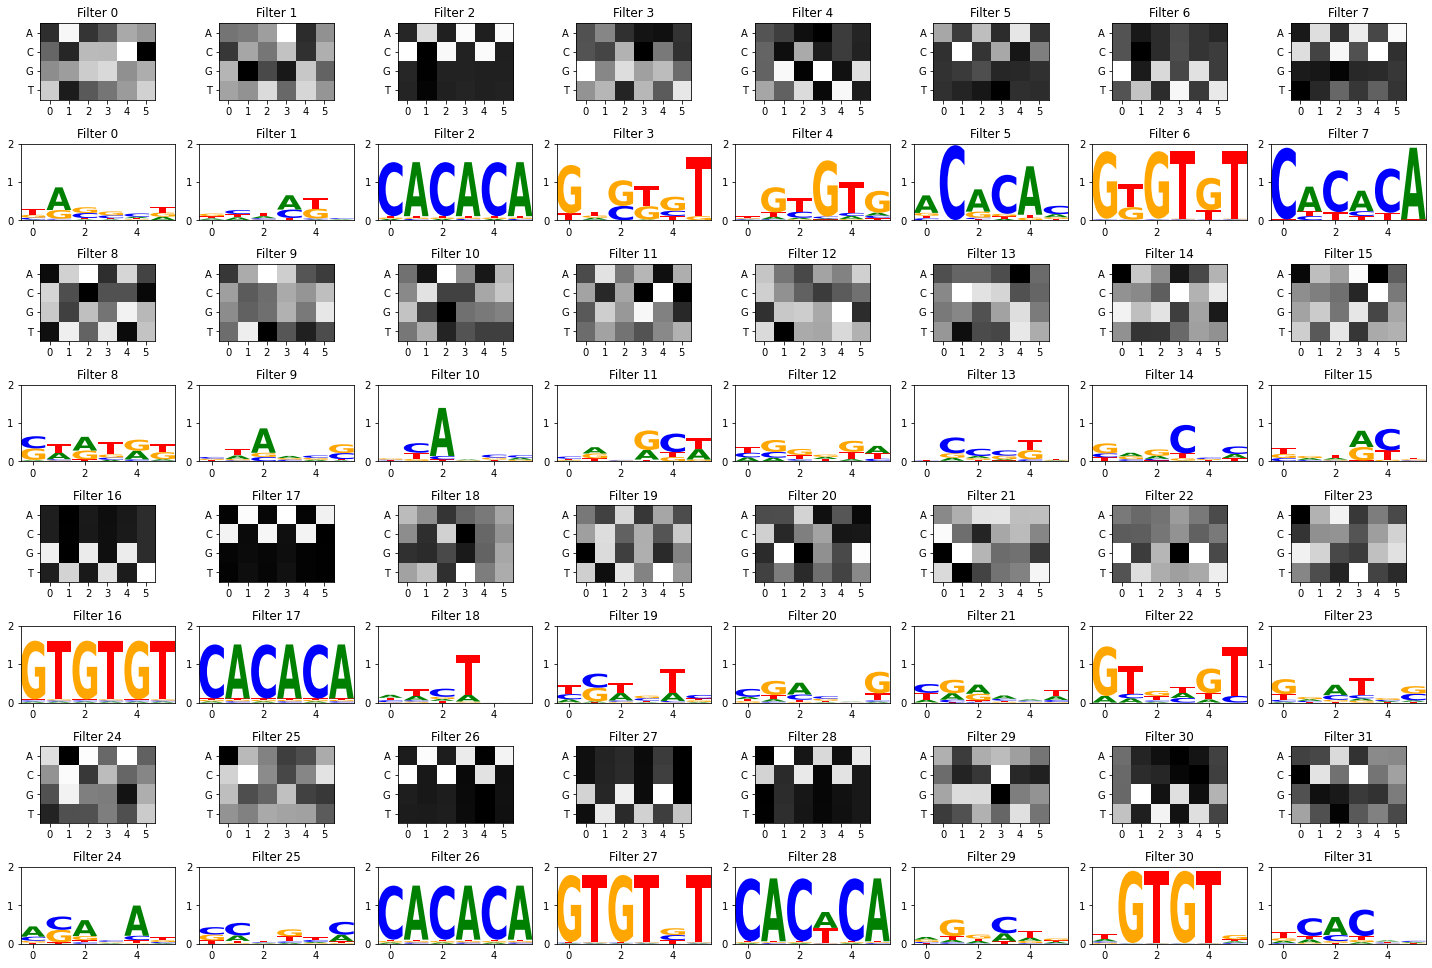

In [41]:
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)

## Old tinkering

In [46]:
w = torch.tensor([10.0,100.0,1.0])
cel = nn.CrossEntropyLoss()
celw = nn.CrossEntropyLoss(weight=w)

In [48]:
a = torch.tensor([[1.0,2.0,3.0],
                  [1.0,3.0,2.0],
                  [3.0,1.0,2.0]])

b = torch.tensor([2,1,2])
c = torch.tensor([0,1,2])

print('normal')
print(cel(a,b))
print(cel(a,c))
print()
print('weighted')
print(celw(a,b))
print(celw(a,c))

normal
tensor(0.7409)
tensor(1.4076)

weighted
tensor(0.4174)
tensor(0.5968)


In [45]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [104]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

p = quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS06320: pred:2 actual:0
EQU24_RS06320: pred:2 actual:0 ([6.231020450592041, -6.871827602386475, 6.793558597564697])
EQU24_RS06855: pred:1 actual:0
EQU24_RS06855: pred:1 actual:0 ([5.818170547485352, 6.306614875793457, -5.028451919555664])
EQU24_RS16240: pred:1 actual:0
EQU24_RS16240: pred:1 actual:0 ([6.875643253326416, 7.228374004364014, -6.141620635986328])


In [93]:
p.tolist()[0]

[6.06266975402832, 2.4189703464508057, -2.8052988052368164]

In [67]:
genes = train_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [85]:
preds

tensor([[9.9989e-01, 1.0368e-04, 8.5303e-06],
        [9.9997e-01, 2.7287e-05, 2.8173e-06],
        [9.8730e-01, 5.0449e-05, 1.2647e-02],
        ...,
        [9.9740e-01, 1.9590e-05, 2.5840e-03],
        [9.9967e-01, 2.5071e-04, 8.1230e-05],
        [9.9950e-01, 4.3107e-04, 6.7942e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [110]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [113]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

done
